# MTI under homo assumption

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from obspy.imaging.beachball import beachball
from obspy.imaging.beachball import beach

from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.linalg import lstsq

from pylops.basicoperators import HStack, VStack
from pylops.utils import dottest
from pylops.utils.wavelets import *
from pylops.optimization.sparsity import *


In [2]:
from pyfrac.modelling.kirchhoff import Kirchhoff
from pyfrac.modelling.trueamp_kirchhoff import Kirchhoff as TAKirchhoff

from pyfrac.mtsolvers.mtimaging import *
from pyfrac.mtsolvers.homo_mti import collect_source_angles, multicomp_Greens_Pwave, pwave_Greens_comp
from pyfrac.mtsolvers.mtutils import get_mt_computation_dict

from pyfrac.visualisation.eventimages import locimage3d

# 3D Model - Homo

In [3]:
# Velocity Model
nx, ny, nz = 47, 51, 75
dx, dy, dz = 4, 4, 4
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

v0 = 1000 # initial velocity
kv = 0. # gradient
vel = v0 * np.ones([nx, ny, nz])

(3, 143)
[[  4.  180.  162.4 144.8 127.2 109.6  92.   74.4  56.8  39.2  21.6   4.
  180.  162.4 144.8]
 [  4.    4.   20.   36.   52.   68.   84.  100.  116.  132.  148.  164.
  164.  180.  196. ]
 [  4.    4.    4.    4.    4.    4.    4.    4.    4.    4.    4.    4.
    4.    4.    4. ]]
[  4.  20.  36.  52.  68.  84. 100. 116. 132. 148. 164. 180. 196.] 200 [  4.   21.6  39.2  56.8  74.4  92.  109.6 127.2 144.8 162.4 180. ] 184


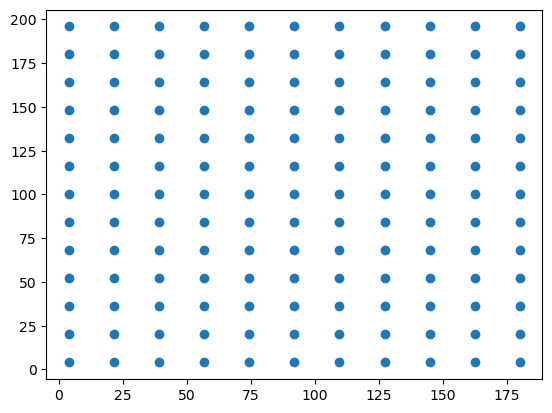

In [4]:
# RECEIVERS
grid_rx_locs = np.linspace(dx, (dx*nx)-2*dx, 11)
grid_ry_locs = np.linspace(dy, (dy*ny)-2*dy, 13)

rx, ry, rz = np.meshgrid(grid_rx_locs,
                         grid_ry_locs,
                         dz) 
recs = np.vstack((rx.flatten(), ry.flatten(), rz.flatten()))
nr = recs.shape[1]

plt.scatter(rx,ry)
print(recs.shape)
print(recs[:,::10])
print(grid_ry_locs, y.max(), grid_rx_locs, x.max())

## Get all necessary components

In [5]:
%%time

# TRAVEL TIME TABLE
trav = Kirchhoff._traveltime_table(z, 
                                   x, 
                                   y=y, 
                                   recs=recs,  
                                   vel=vel, 
                                   mode='eikonal')

TTT_full = trav.reshape(nx,ny,nz,nr).transpose([3,0,1,2])

CPU times: user 15.2 s, sys: 152 ms, total: 15.4 s
Wall time: 15.4 s


In [6]:
# AMPLITUDE TERMS
gamma_sourceangles, dist_table = collect_source_angles(x,y,z, reclocs=recs, nc=3)

In [7]:
# Source Parameters
omega_p = 30  # Assume central frequency of 25Hz
sloc_ind = [nx//2, ny//2, nz//2]  # As indices of velocity model

### AREA OF INTEREST

In [8]:
# Make cube area of interest as can't consider the full subsurface body
hwin_nx_aoi, hwin_ny_aoi, hwin_nz_aoi = 15, 13, 11  # half windows to place source in center of region of interest
xsi, xfi = sloc_ind[0]-hwin_nx_aoi, sloc_ind[0]+hwin_nx_aoi+1   # start/end index of x-region of interest
ysi, yfi = sloc_ind[1]-hwin_ny_aoi, sloc_ind[1]+hwin_ny_aoi+1   # start/end index of y-region of interest
zsi, zfi = sloc_ind[2]-hwin_nz_aoi, sloc_ind[2]+hwin_nz_aoi+1   # start/end index of z-region of interest

In [9]:
# Parameters only for the area of interest
gamma_sourceangles_aoi = gamma_sourceangles[:, :, xsi:xfi, ysi:yfi, zsi:zfi]
dist_table_aoi = dist_table[:, xsi:xfi, ysi:yfi, zsi:zfi]
tt_table_aoi = TTT_full[:, xsi:xfi, ysi:yfi, zsi:zfi]

nr, nx_aoi, ny_aoi, nz_aoi = tt_table_aoi.shape
print(nr, nx_aoi, ny_aoi, nz_aoi)

143 31 27 23


In [10]:
MT_comp_dict = get_mt_computation_dict()  # This keeps everything nice and clean in the later G compute

## Compute Greens for area of interest

In [11]:
Gx, Gy, Gz = multicomp_Greens_Pwave(nxyz=[nx_aoi, ny_aoi, nz_aoi],
                                    nr=nr,
                                    gamma_sourceangles=gamma_sourceangles_aoi,
                                    dist_table=dist_table_aoi,
                                    vel=vel,
                                    MT_comp_dict=MT_comp_dict,
                                    omega_p=1,
                                    )

In [12]:
Gx.shape

(6, 143, 31, 27, 23)

# Moment Tensor Kirchhoff Imaging

### MAKE OPERATOR

In [13]:
# Time and Wavelet Information
nt = 251
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=omega_p)

In [14]:
Mstack_Op = multicomp_pwave_mtioperator(x=x[xsi:xfi],
                                        y=y[ysi:yfi],
                                        z=z[zsi:zfi],
                                        recs=recs,
                                        t=t,
                                        wav=wav,
                                        wavc=wavc,
                                        tt_table=tt_table_aoi,
                                        Gx=Gx,
                                        Gy=Gy,
                                        Gz=Gz,
                                        Ms_scaling = 1e6,
                                        engine='numba'
                                        )

Dot test passed, v^H(Opu)=0.275039042240687 - u^H(Op^Hv)=0.2750390422406872


## INVERSE CRIME - Make data with forward operation

In [15]:
# Modelled MT
MT_aoi = np.zeros([6, nx_aoi, ny_aoi, nz_aoi])  # MT components as images
MT_selected =-1 * np.array([0,0,0,1,0,0]) #  np.array([1,1,1,0,0,0]) 
MT_aoi[:, nx_aoi//2, ny_aoi//2, nz_aoi//2] = MT_selected

# Generated Data
data = Mstack_Op @ MT_aoi.ravel()
data = data.reshape(3, nr, nt)

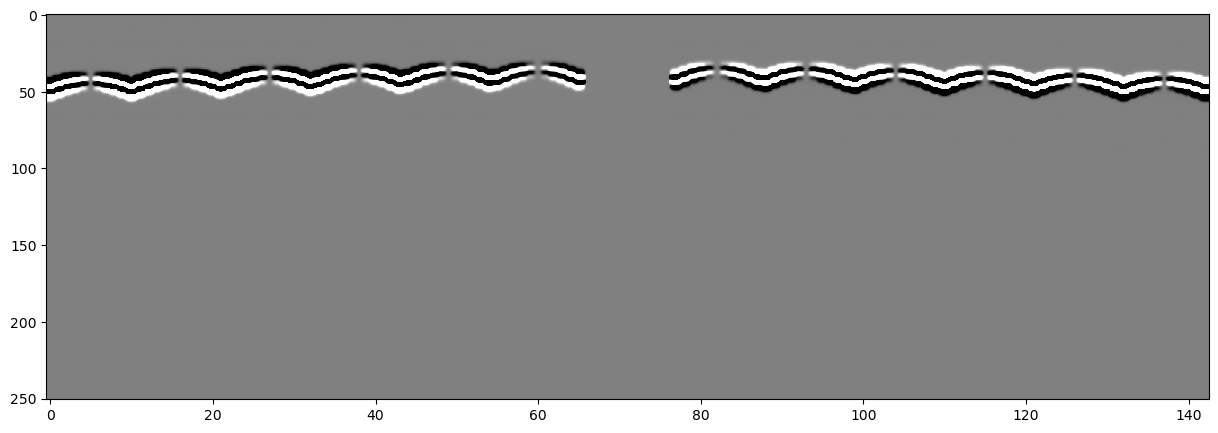

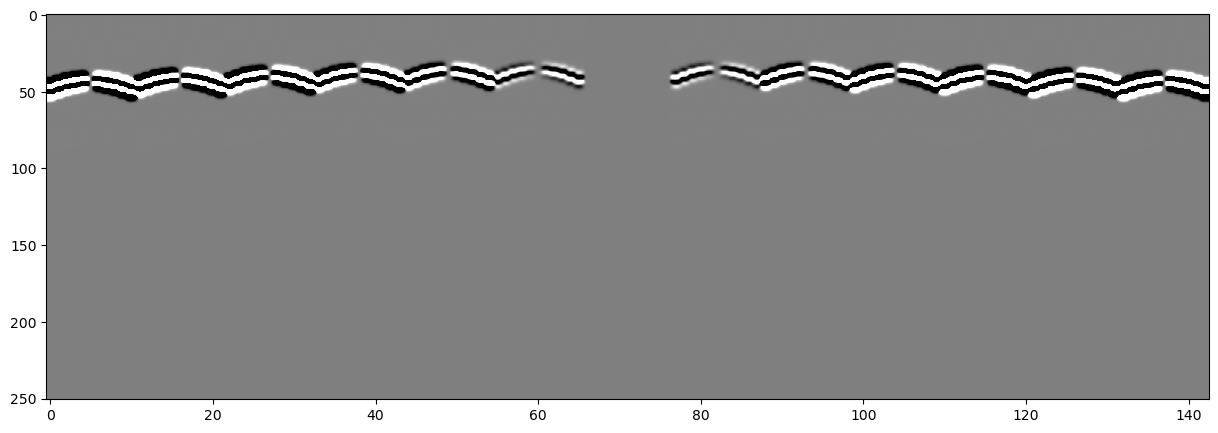

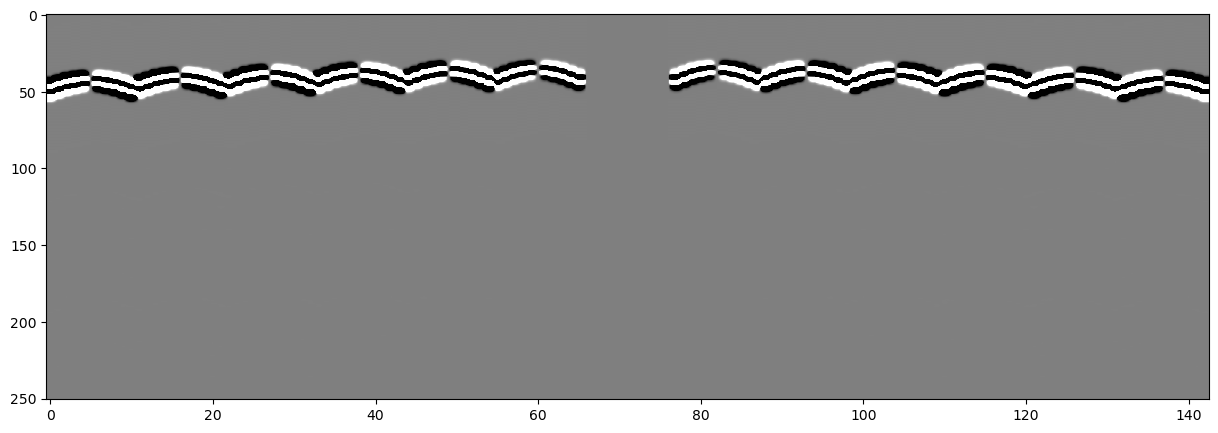

In [16]:
plt.figure(figsize=(15, 5))
plt.imshow(data[0].reshape(-1, nt).T, cmap='gray', vmin=-1e-7, vmax=1e-7)
plt.axis('tight')

plt.figure(figsize=(15, 5))
plt.imshow(data[1].reshape(-1, nt).T, cmap='gray', vmin=-1e-7, vmax=1e-7)
plt.axis('tight')

plt.figure(figsize=(15, 5))
plt.imshow(data[2].reshape(-1, nt).T, cmap='gray', vmin=-1e-7, vmax=1e-7)
plt.axis('tight');

In [17]:
nxyz=[nx_aoi, ny_aoi, nz_aoi]

# ADJOINT
mt_adj = adjoint_mtmodelling(data, Mstack_Op, nxyz)

# LSQR
mt_inv = lsqr_mtsolver(data, Mstack_Op, nxyz)

# FISTA
mt_fista = fista_mtsolver(data, Mstack_Op, nxyz, fista_niter=100, fista_damping=1e-13, verbose=True)


 
LSQR            Least-squares solution of  Ax = b
The matrix A has 107679 rows and 115506 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 0.00e+00                 conlim = 1.00e+08
btol = 0.00e+00               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.738e-04  1.738e-04    1.0e+00  9.8e+01
     1 -2.18482e-06   8.795e-05  8.795e-05    5.1e-01  5.5e-01   2.0e-02  1.0e+00
     2 -5.02460e-06   6.194e-05  6.194e-05    3.6e-01  3.3e-01   2.6e-02  2.2e+00
     3 -1.51960e-06   4.837e-05  4.837e-05    2.8e-01  2.2e-01   3.0e-02  3.7e+00
     4  4.09412e-06   4.052e-05  4.052e-05    2.3e-01  1.6e-01   3.4e-02  5.3e+00
     5  5.05272e-06   3.620e-05  3.620e-05    2.1e-01  1.3e-01   3.7e-02  7.0e+00
     6  5.73908e-06   3.281e-05  3.281e-05    1.9e-01  1.1e-01   3.9e-02  9.1e+00
     7  3.50211e-06   3.027e-05  3.027e-05    1.7e-01  9.6e-02   4.2e-02  1.1e+01
     8 -1.10058e-06   2.835e-0

In [19]:
mt_fista.max()

0.0011755252039011145

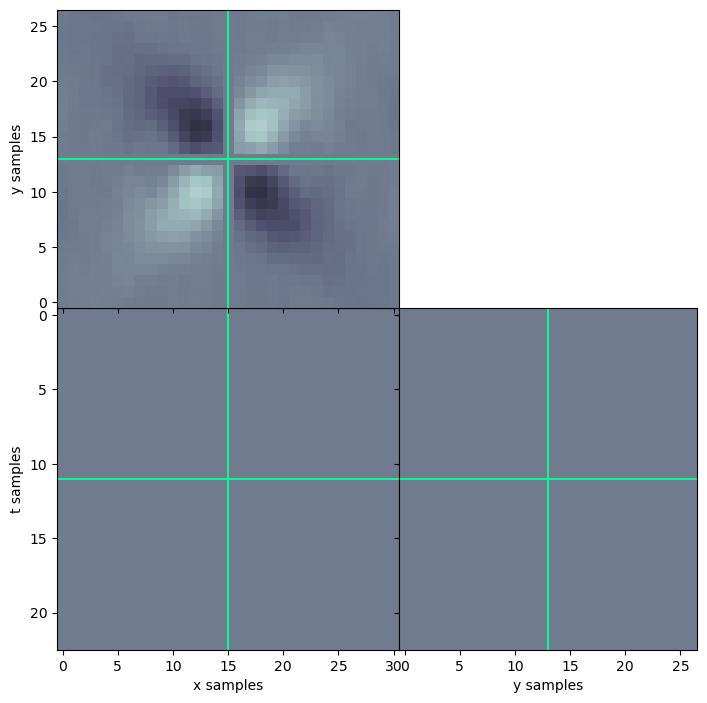

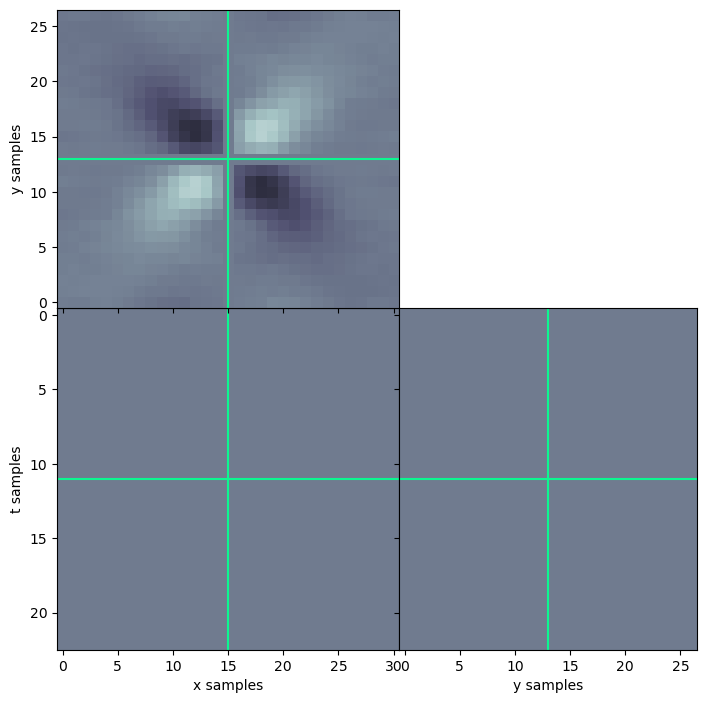

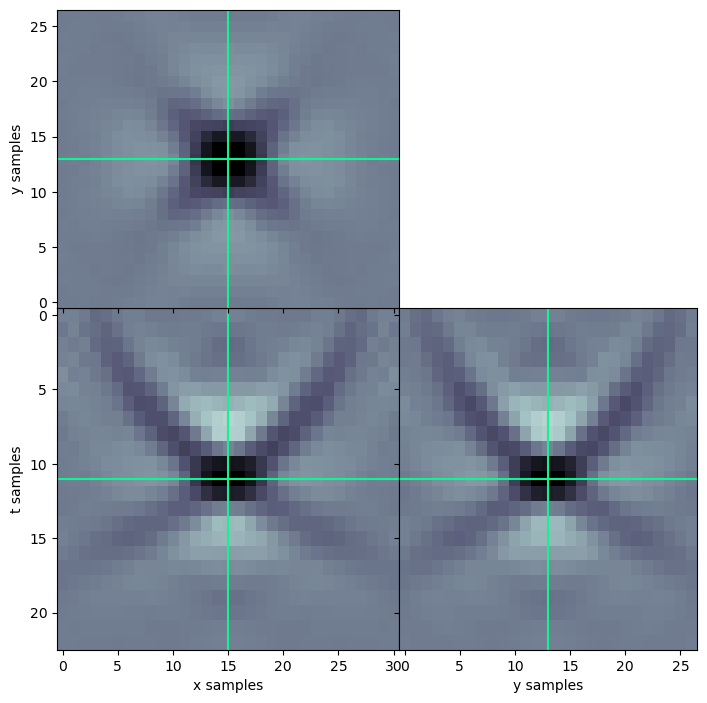

In [21]:
locimage3d(mt_fista[0], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3])
locimage3d(mt_fista[1], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3])
locimage3d(mt_fista[3], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3]);

In [ ]:
MT_aoi_adj = Mstack_Op.H @ data.ravel()
MT_aoi_adj = MT_aoi_adj.reshape(MT_aoi.shape)

MT_aoi_inv = lsqr(Mstack_Op, data.ravel(), iter_lim=50, atol=0, btol=0, show=True)[0]
MT_aoi_inv = MT_aoi_inv.reshape(MT_aoi.shape)

data_inv = Mstack_Op @ MT_aoi_inv.ravel()

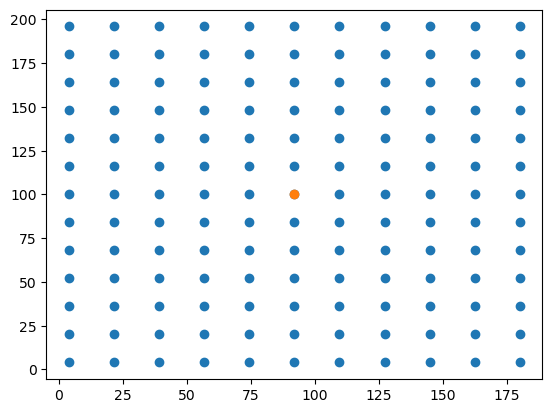

In [18]:
plt.scatter(rx,ry)
plt.scatter(recs[0, 71],recs[1, 71])

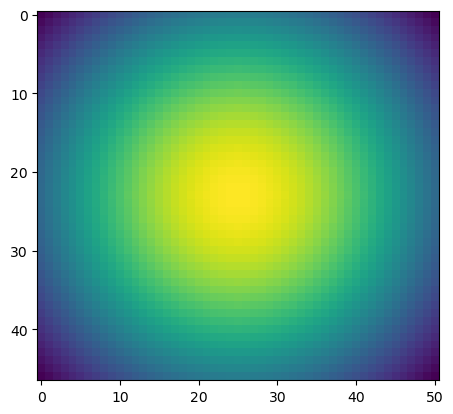

In [19]:
plt.imshow(gamma_sourceangles[2, 71, :, :, sloc_ind[2]])

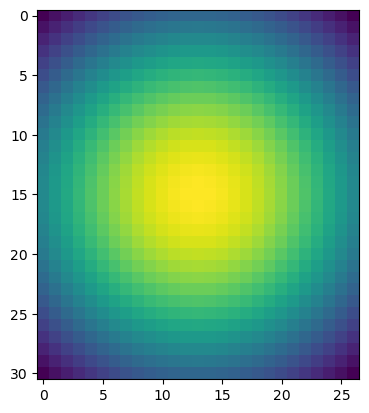

In [21]:
plt.imshow(Gz[2, 71, :, :, sloc_ind[2] - zsi])

# MT imaging with VZ

In [23]:
MT_aoi = np.zeros([6, nx_aoi, ny_aoi, nz_aoi])  # MT components as images
MT_selected =-1 * np.array([0,0,0,1,0,0]) #  np.array([1,1,1,0,0,0]) 
MT_aoi[:, nx_aoi//2, ny_aoi//2, nz_aoi//2] = MT_selected

In [26]:
# Build 6 True Amp Kirchoff Operators
Ms_scaling = 1e6 # to avoid working with small numbers in inversion
Ms_Op = [TAKirchhoff(z=z[zsi:zfi],
                     x=x[xsi:xfi], 
                     y=y[ysi:yfi],
                     t=t,
                     srcs=recs[:, :1], 
                     recs=recs, 
                     wav=wav, 
                     wavcenter=wavc, 
                     wavfilter=True,
                     trav = tt_table_aoi.reshape(nr, -1).T,
                     amp = Ms_scaling * Gz[icomp].reshape(nr, -1).T.astype(np.float32),
                     engine='numba') 
         for icomp in range(6)]

# check operator with dottest
for icomp in range(6):
    _ = dottest(Ms_Op[icomp], verb=True, atol=1e-5)

Dot test passed, v^H(Opu)=0.09977580730800178 - u^H(Op^Hv)=0.09977580730800306
Dot test passed, v^H(Opu)=-1.282556257049084 - u^H(Op^Hv)=-1.282556257049083
Dot test passed, v^H(Opu)=4.825742633567147 - u^H(Op^Hv)=4.825742633567143
Dot test passed, v^H(Opu)=-0.22946045574357649 - u^H(Op^Hv)=-0.22946045574357643
Dot test passed, v^H(Opu)=0.4797334904882956 - u^H(Op^Hv)=0.47973349048829483
Dot test passed, v^H(Opu)=2.104583183700994 - u^H(Op^Hv)=2.1045831837009934


In [27]:
Mstack_Op = HStack(Ms_Op, forceflat=True)

In [28]:
data = Mstack_Op @ MT_aoi.ravel()

MT_aoi_adj = Mstack_Op.H @ data.ravel()
MT_aoi_adj = MT_aoi_adj.reshape(MT_aoi.shape)

MT_aoi_inv = lsqr(Mstack_Op, data.ravel(), iter_lim=50, atol=0, btol=0, show=True)[0]
MT_aoi_inv = MT_aoi_inv.reshape(MT_aoi.shape)

data_inv = Mstack_Op @ MT_aoi_inv.ravel()

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 35893 rows and 115506 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 0.00e+00                 conlim = 1.00e+08
btol = 0.00e+00               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   4.281e-03  4.281e-03    1.0e+00  1.0e+02
     1 -8.36190e-07   2.257e-03  2.257e-03    5.3e-01  5.9e-01   5.1e-01  1.0e+00
     2 -3.40290e-06   1.575e-03  1.575e-03    3.7e-01  3.5e-01   6.9e-01  2.2e+00
     3 -6.28507e-06   1.162e-03  1.162e-03    2.7e-01  2.4e-01   8.1e-01  3.7e+00
     4 -4.27257e-06   9.222e-04  9.222e-04    2.2e-01  1.8e-01   9.0e-01  5.3e+00
     5  7.96165e-07   7.778e-04  7.778e-04    1.8e-01  1.7e-01   9.7e-01  7.1e+00
     6  3.88858e-06   6.986e-04  6.986e-04    1.6e-01  1.4e-01   1.1e+00  8.9e+00
     7  5.91722e-06   6.302e-04  6.302e-04    1.5e-01  1.3e-01   1.2e+00  1.1e+01
     8  7.06713e-06   5.602e-04

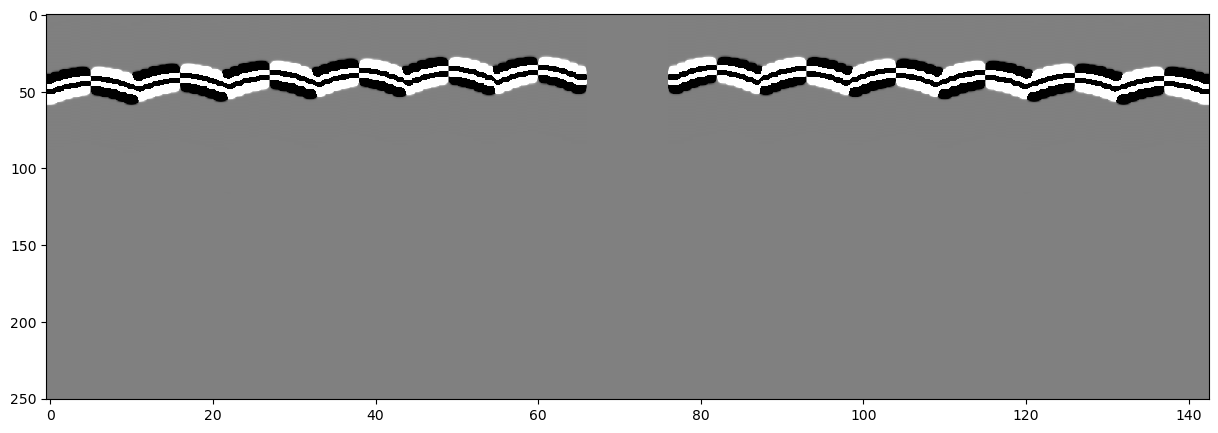

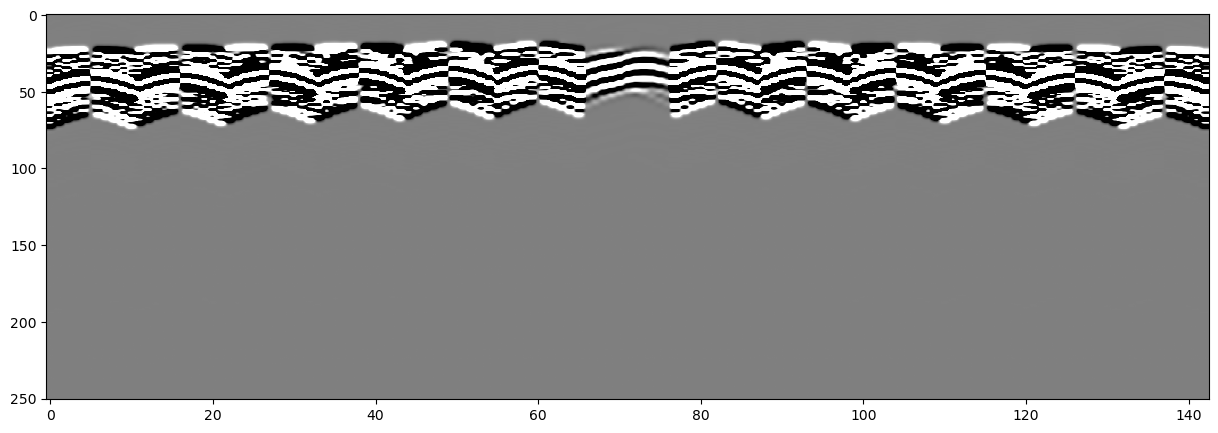

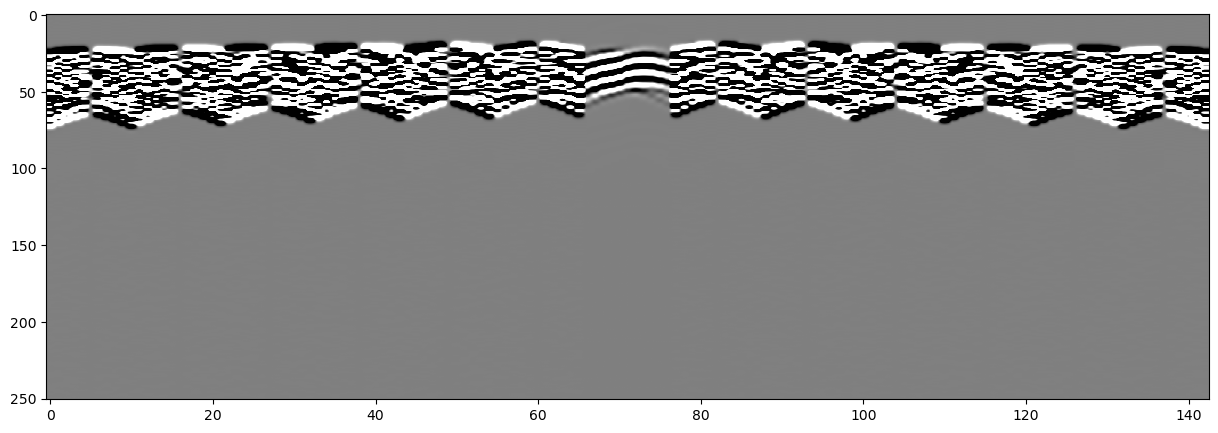

In [29]:
plt.figure(figsize=(15, 5))
plt.imshow(data.reshape(-1, nt).T, cmap='gray', vmin=-1e-7, vmax=1e-7)
plt.axis('tight');

plt.figure(figsize=(15, 5))
plt.imshow(data_inv.reshape(-1, nt).T, cmap='gray', vmin=-1e-7, vmax=1e-7)
plt.axis('tight')

plt.figure(figsize=(15, 5))
plt.imshow((data-data_inv).reshape(-1, nt).T, cmap='gray', vmin=-1e-7, vmax=1e-7)
plt.axis('tight');

In [93]:
MT_aoi_fista = fista(Mstack_Op, data.ravel(), np.zeros_like(MT_aoi).ravel(), niter=100, eps=1e-13, show=True)[0]
MT_aoi_fista = MT_aoi_fista.reshape(MT_aoi.shape)

data_fista = Mstack_Op @ MT_aoi_fista.ravel()

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 35893 rows and 115506 cols
eps = 1.000000e-13	tol = 1.000000e-10	niter = 100
alpha = 5.677754e+07	thresh = 2.838877e-06
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1       0.0000e+00         1.184e-13   1.584e-13   2.811e-03
     2       0.0000e+00         8.400e-14   1.381e-13   1.363e-03
     3       0.0000e+00         6.278e-14   1.262e-13   1.181e-03
     4       0.0000e+00         4.913e-14   1.187e-13   1.044e-03
     5      -0.0000e+00         4.013e-14   1.135e-13   9.297e-04
     6      -0.0000e+00         3.402e-14   1.096e-13   8.376e-04
     7      -0.0000e+00         2.974e-14   1.064e-13   7.668e-04
     8      -0.0000e+00         2.664e-14   1.036e-13   7.089e-04
     9      -0.0000e+00         2.435e-14   1.011e-13   6.692e-04
    10      -

(<Figure size 800x800 with 3 Axes>,
 (<Axes: xlabel='x samples', ylabel='t samples'>,
  <Axes: xlabel='y samples'>,
  <Axes: ylabel='y samples'>))

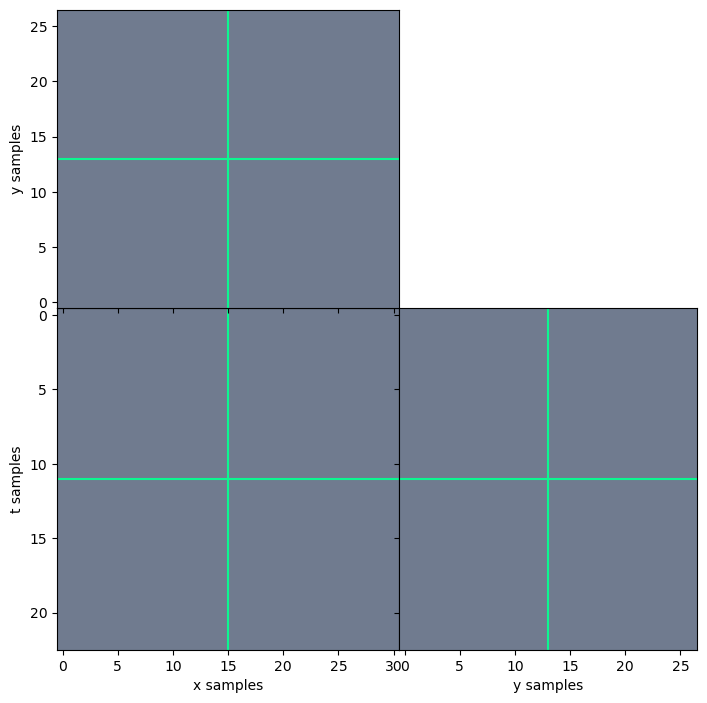

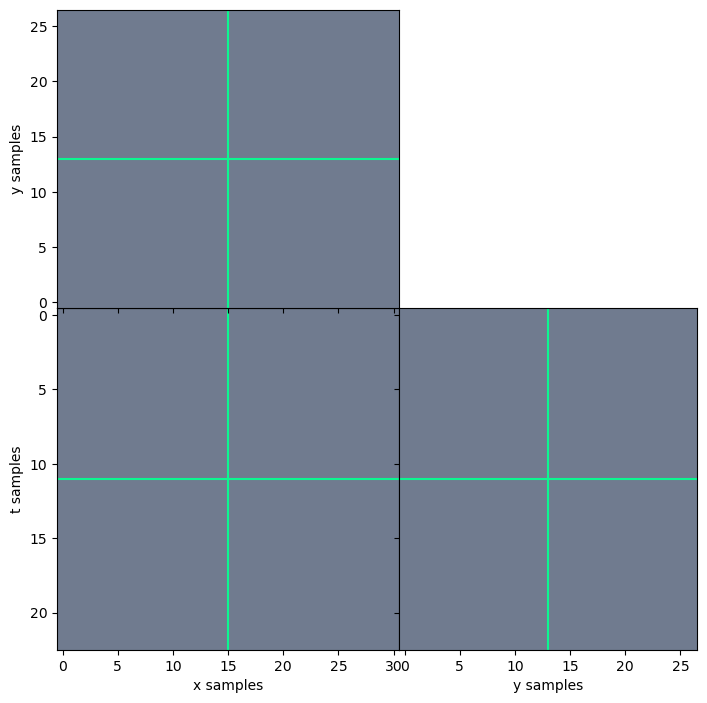

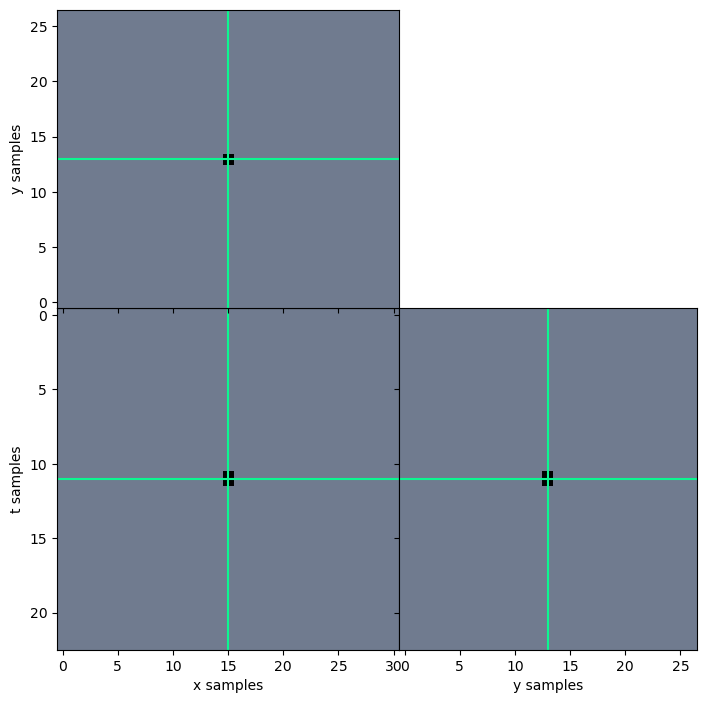

In [89]:
locimage3d(MT_aoi[0], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1, 1])
locimage3d(MT_aoi[1], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1, 1])
locimage3d(MT_aoi[3], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1, 1])

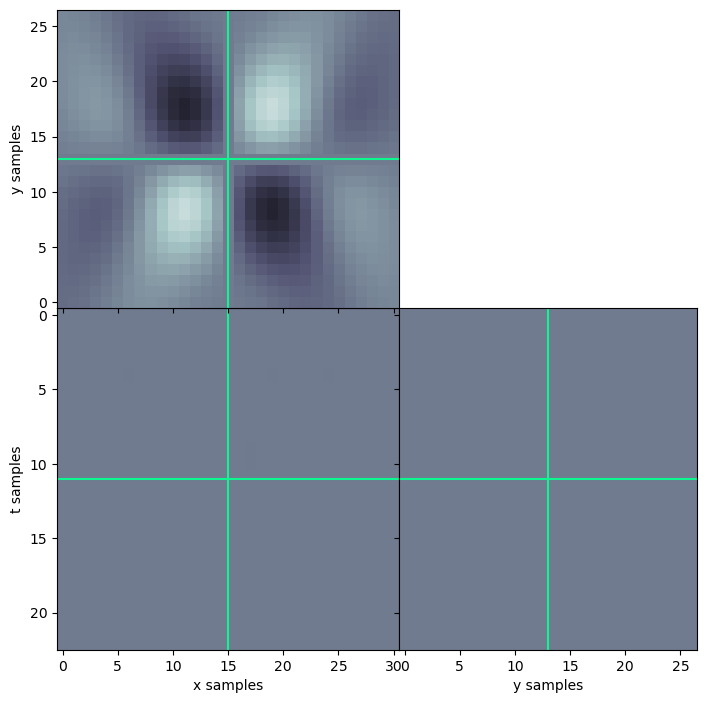

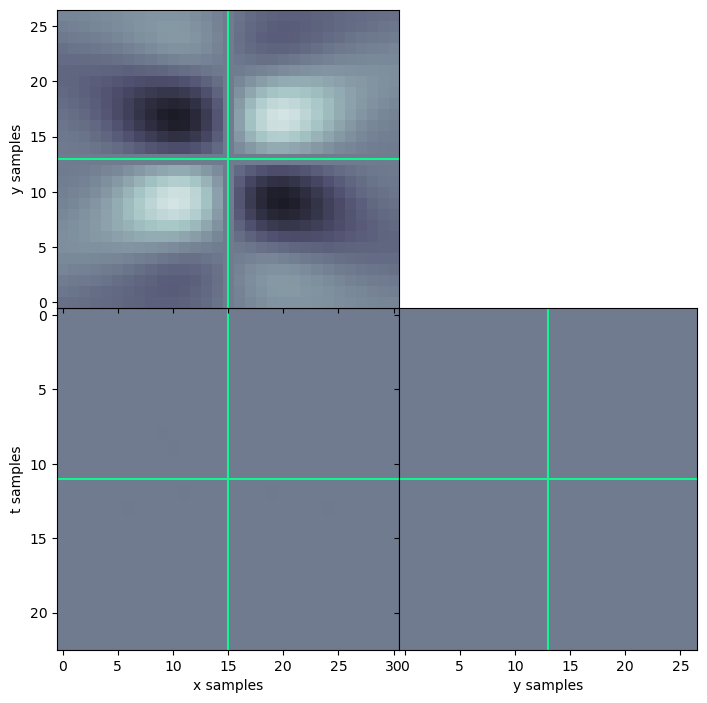

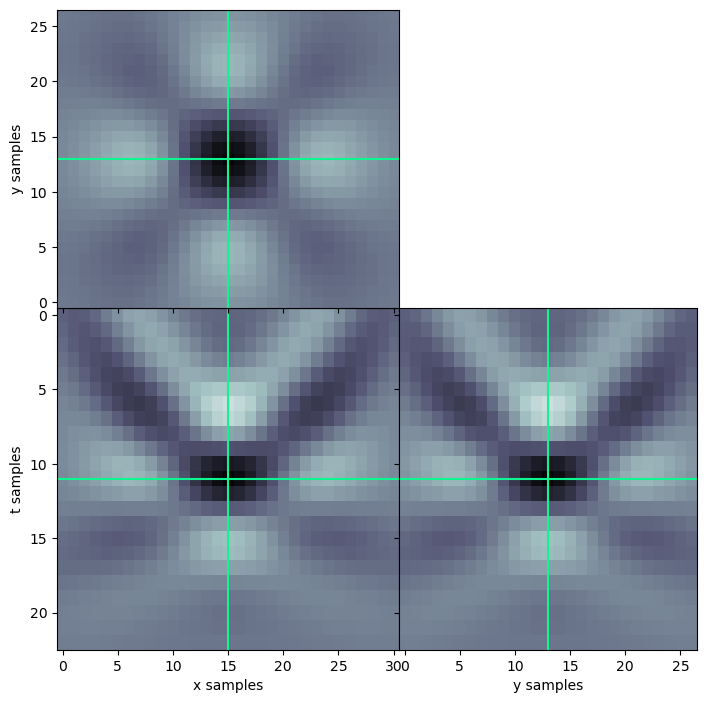

In [90]:
locimage3d(MT_aoi_adj[0], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-5e-13, 5e-13])
locimage3d(MT_aoi_adj[1], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-5e-13, 5e-13])
locimage3d(MT_aoi_adj[3], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-5e-13, 5e-13]);

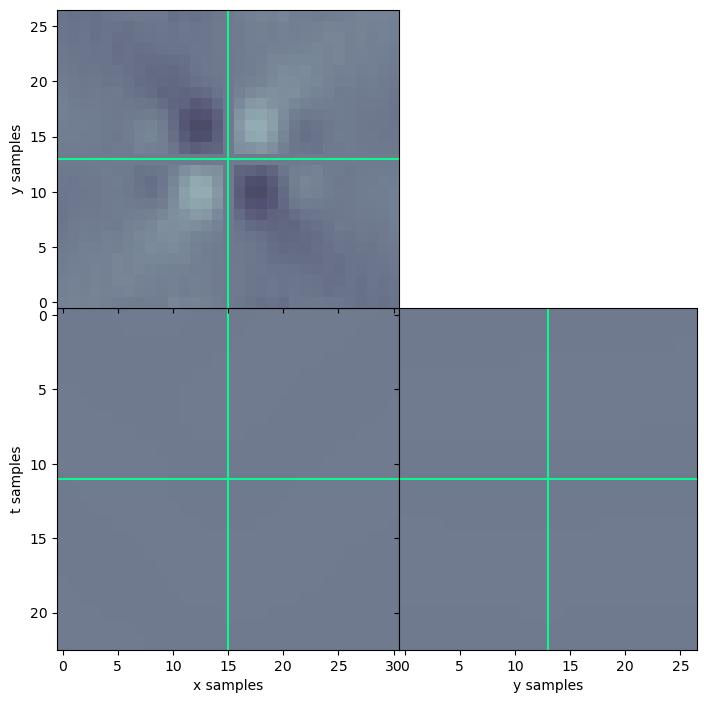

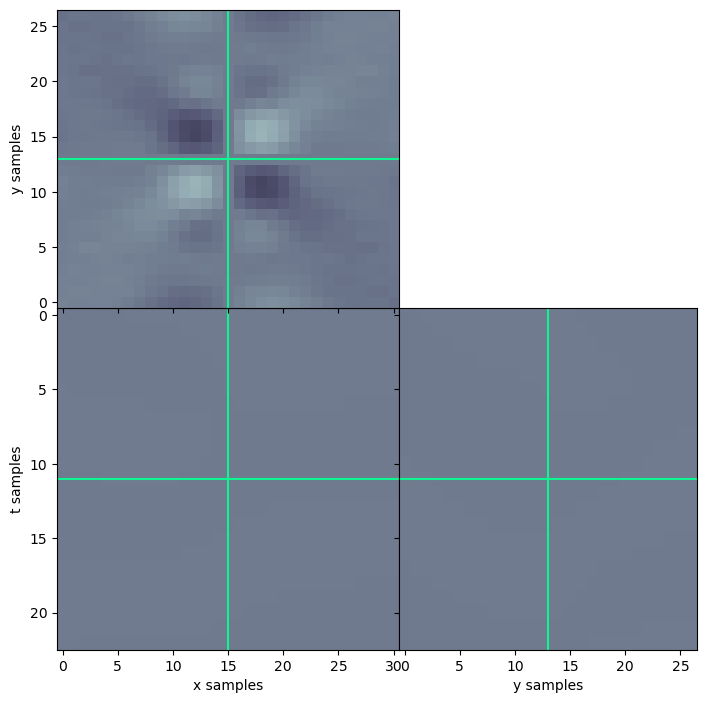

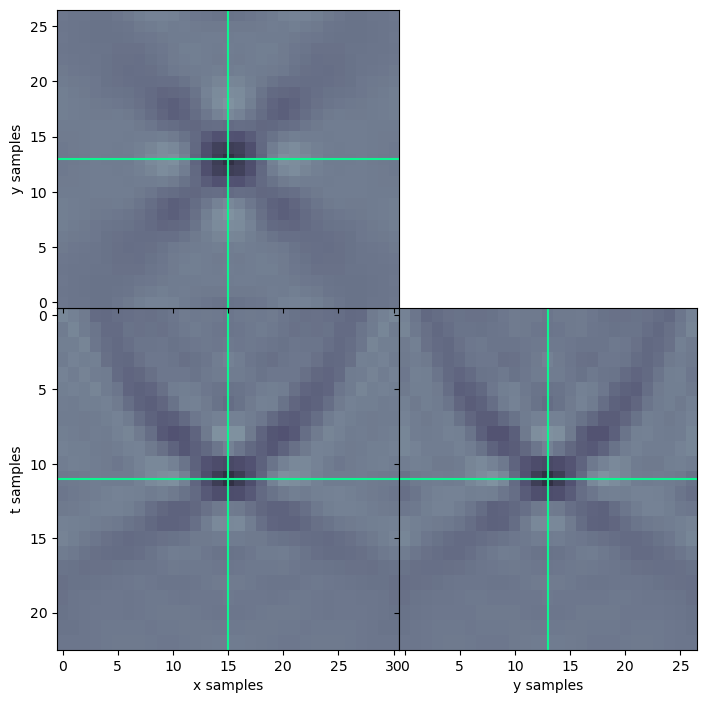

In [91]:
locimage3d(MT_aoi_inv[0], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3])
locimage3d(MT_aoi_inv[1], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3])
locimage3d(MT_aoi_inv[3], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3]);

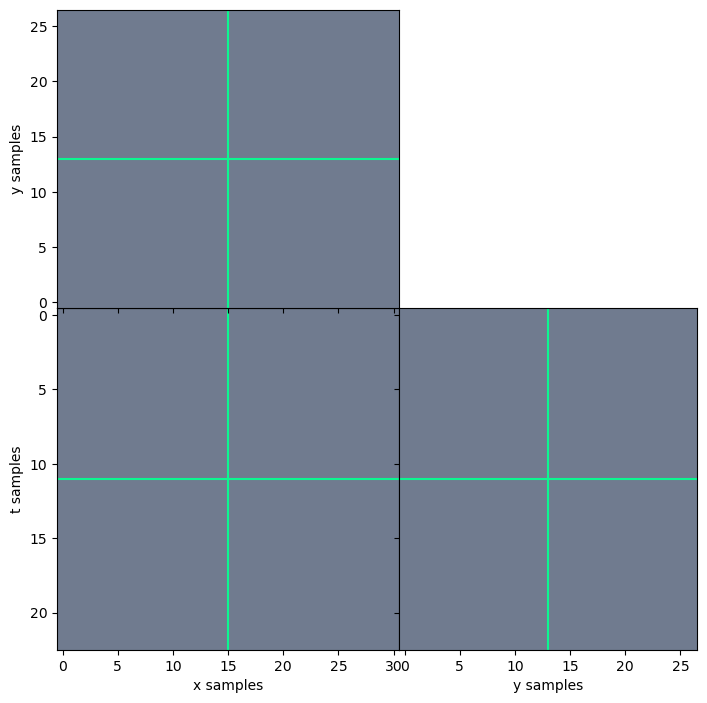

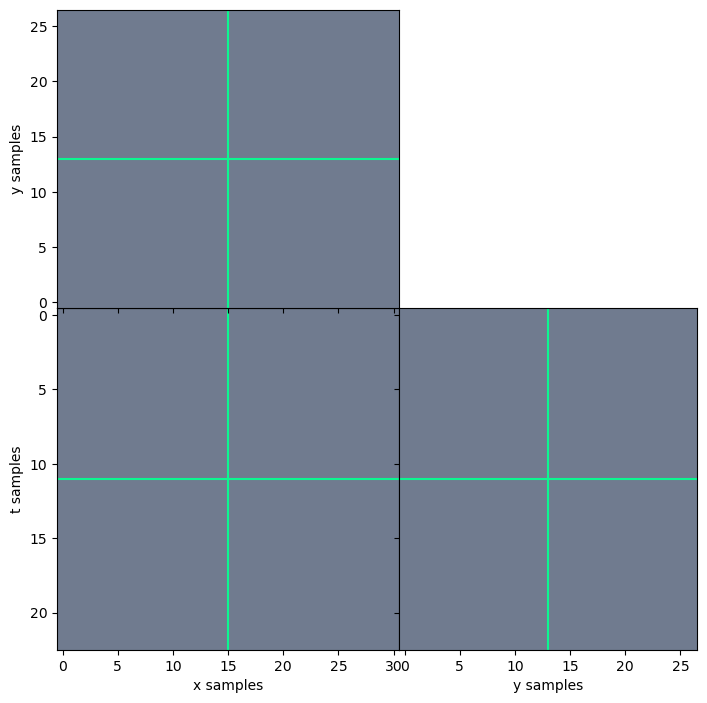

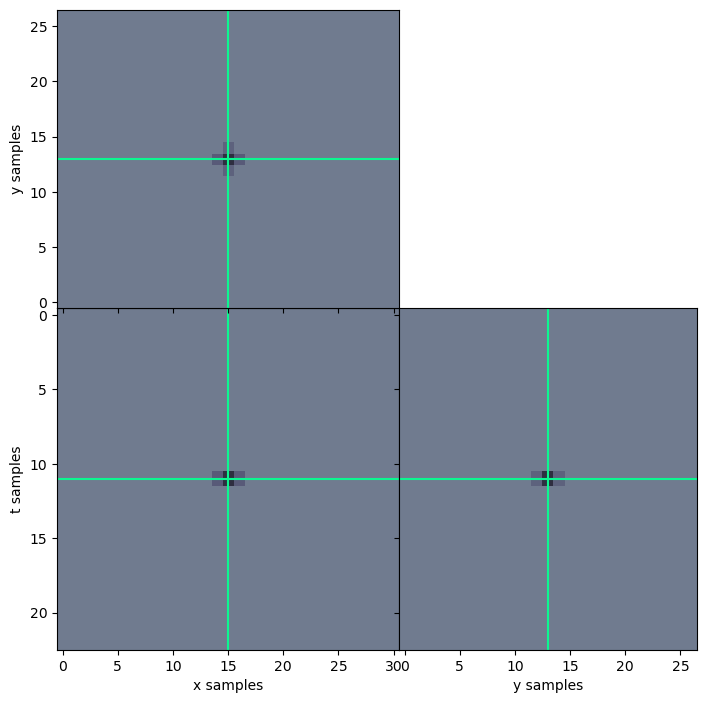

In [94]:
locimage3d(MT_aoi_fista[0], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3])
locimage3d(MT_aoi_fista[1], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3])
locimage3d(MT_aoi_fista[3], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3]);

## MT imaging with VX,VY,VZ

In [99]:
# Build 6 True Amp Kirchoff Operators
Ms_scaling = 1e6 # to avoid working with small numbers in inversion
Mx_Op = [TAKirchhoff(z=z[zsi:zfi],
                     x=x[xsi:xfi], 
                     y=y[ysi:yfi],
                     t=t,
                     srcs=recs[:, :1], 
                     recs=recs, 
                     wav=wav, 
                     wavcenter=wavc, 
                     wavfilter=True,
                     trav = tt_table_aoi.reshape(nr, -1).T,
                     amp = Ms_scaling * Gx_aoi[icomp].reshape(nr, -1).T.astype(np.float32),
                     engine='numba') 
         for icomp in range(6)]

My_Op = [TAKirchhoff(z=z[zsi:zfi],
                     x=x[xsi:xfi], 
                     y=y[ysi:yfi],
                     t=t,
                     srcs=recs[:, :1], 
                     recs=recs, 
                     wav=wav, 
                     wavcenter=wavc, 
                     wavfilter=True,
                     trav = tt_table_aoi.reshape(nr, -1).T,
                     amp = Ms_scaling * Gy_aoi[icomp].reshape(nr, -1).T.astype(np.float32),
                     engine='numba') 
         for icomp in range(6)]

Mz_Op = [TAKirchhoff(z=z[zsi:zfi],
                     x=x[xsi:xfi], 
                     y=y[ysi:yfi],
                     t=t,
                     srcs=recs[:, :1], 
                     recs=recs, 
                     wav=wav, 
                     wavcenter=wavc, 
                     wavfilter=True,
                     trav = tt_table_aoi.reshape(nr, -1).T,
                     amp = Ms_scaling * Gz_aoi[icomp].reshape(nr, -1).T.astype(np.float32),
                     engine='numba') 
         for icomp in range(6)]

Mxstack_Op = HStack(Mx_Op, forceflat=True)
Mystack_Op = HStack(My_Op, forceflat=True)
Mzstack_Op = HStack(Mz_Op, forceflat=True)

Mstack_Op = VStack([Mxstack_Op, Mystack_Op, Mzstack_Op])

# check operator with dottest
_ = dottest(Mstack_Op, verb=True, atol=1e-5)

Dot test passed, v^H(Opu)=0.20261375319525335 - u^H(Op^Hv)=0.202613753195254


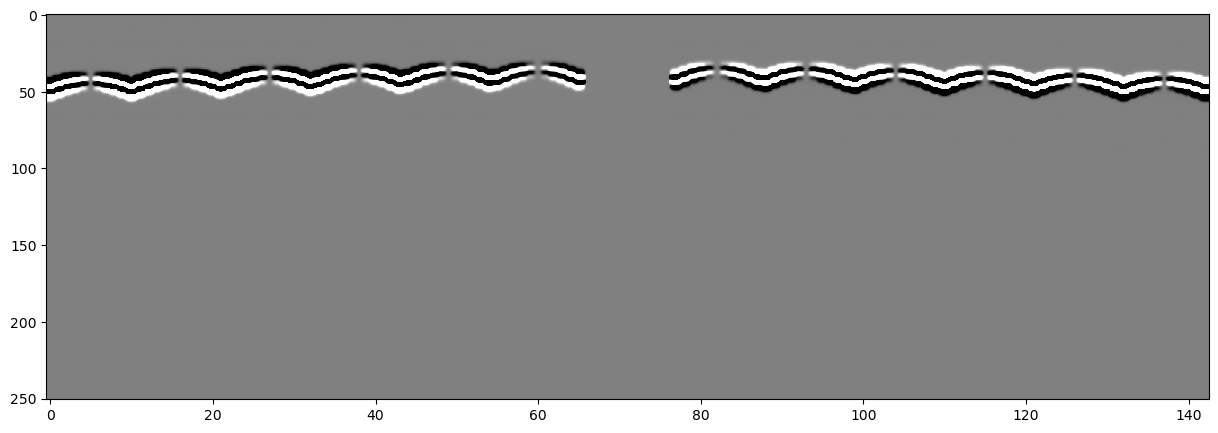

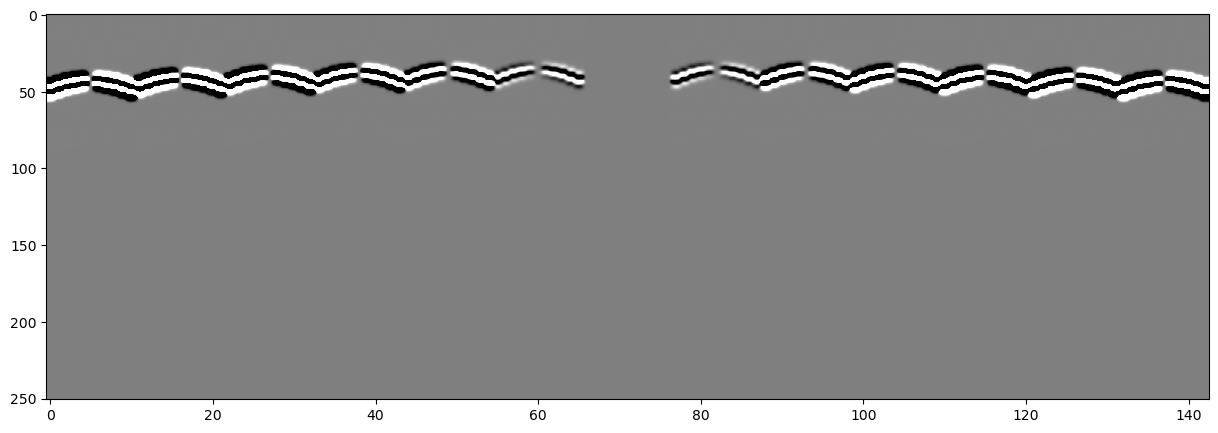

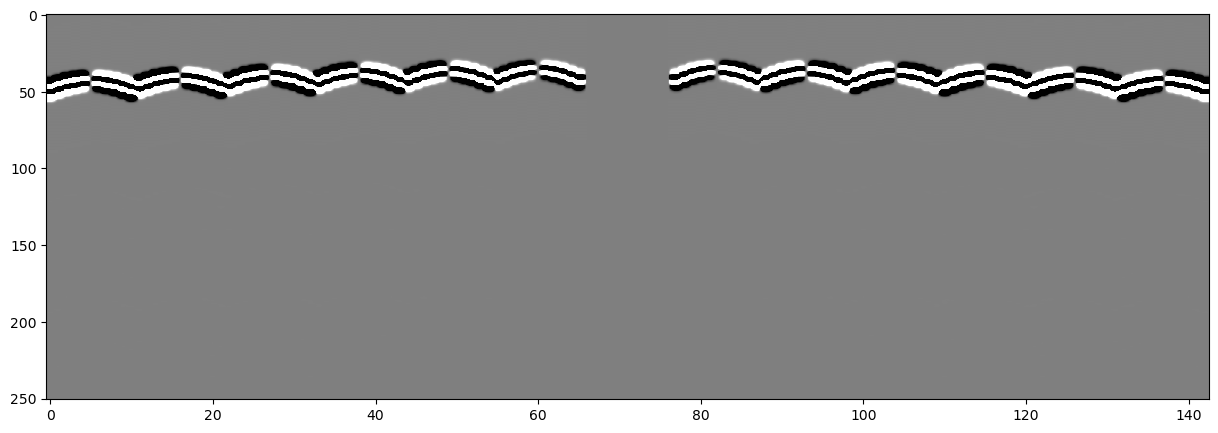

In [100]:
data = Mstack_Op @ MT_aoi.ravel()

data = data.reshape(3, nr, nt)

plt.figure(figsize=(15, 5))
plt.imshow(data[0].reshape(-1, nt).T, cmap='gray', vmin=-1e-7, vmax=1e-7)
plt.axis('tight')

plt.figure(figsize=(15, 5))
plt.imshow(data[1].reshape(-1, nt).T, cmap='gray', vmin=-1e-7, vmax=1e-7)
plt.axis('tight')

plt.figure(figsize=(15, 5))
plt.imshow(data[2].reshape(-1, nt).T, cmap='gray', vmin=-1e-7, vmax=1e-7)
plt.axis('tight');


In [101]:
data = Mstack_Op @ MT_aoi.ravel()

MT_aoi_adj = Mstack_Op.H @ data.ravel()
MT_aoi_adj = MT_aoi_adj.reshape(MT_aoi.shape)

MT_aoi_inv = lsqr(Mstack_Op, data.ravel(), iter_lim=50, atol=0, btol=0, show=True)[0]
MT_aoi_inv = MT_aoi_inv.reshape(MT_aoi.shape)

data_inv = Mstack_Op @ MT_aoi_inv.ravel()

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 107679 rows and 115506 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 0.00e+00                 conlim = 1.00e+08
btol = 0.00e+00               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.738e-04  1.738e-04    1.0e+00  9.8e+01
     1 -2.18482e-06   8.795e-05  8.795e-05    5.1e-01  5.5e-01   2.0e-02  1.0e+00
     2 -5.02460e-06   6.194e-05  6.194e-05    3.6e-01  3.3e-01   2.6e-02  2.2e+00
     3 -1.51960e-06   4.837e-05  4.837e-05    2.8e-01  2.2e-01   3.0e-02  3.7e+00
     4  4.09412e-06   4.052e-05  4.052e-05    2.3e-01  1.6e-01   3.4e-02  5.3e+00
     5  5.05272e-06   3.620e-05  3.620e-05    2.1e-01  1.3e-01   3.7e-02  7.0e+00
     6  5.73908e-06   3.281e-05  3.281e-05    1.9e-01  1.1e-01   3.9e-02  9.1e+00
     7  3.50211e-06   3.027e-05  3.027e-05    1.7e-01  9.6e-02   4.2e-02  1.1e+01
     8 -1.10058e-06   2.835e-0

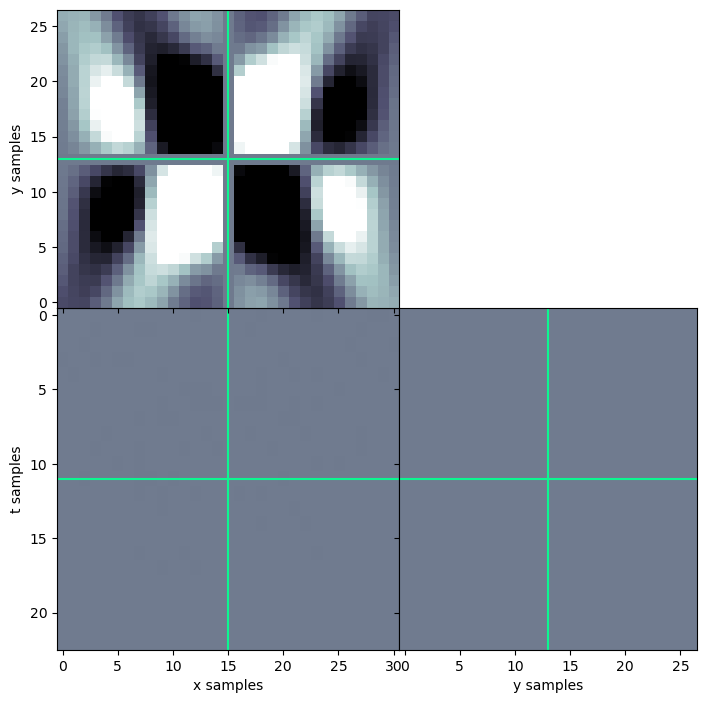

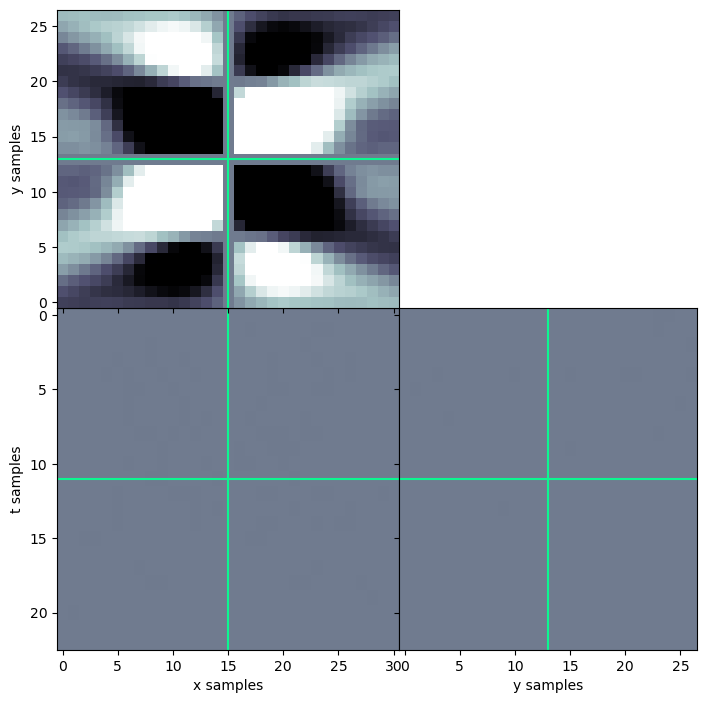

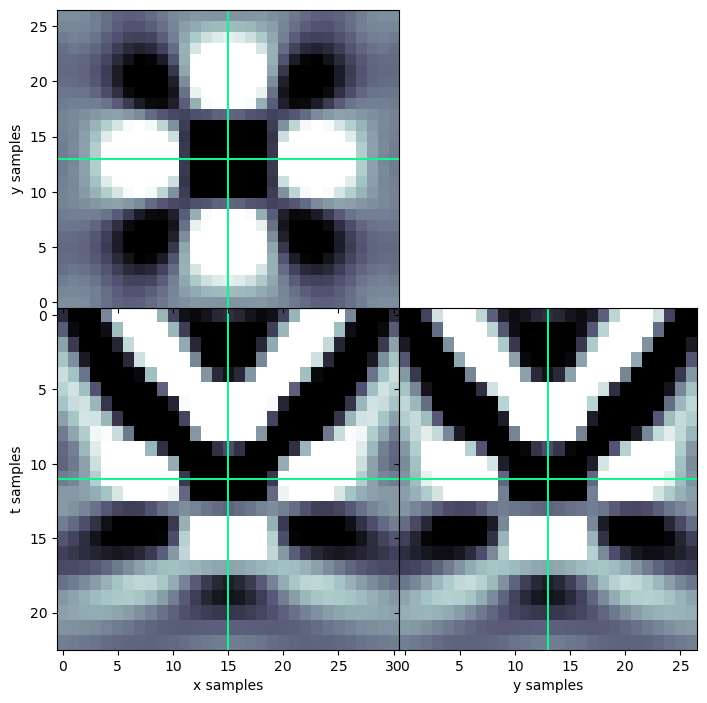

In [107]:
locimage3d(MT_aoi_adj[0], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-5e-9, 5e-9])
locimage3d(MT_aoi_adj[1], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-5e-9, 5e-9])
locimage3d(MT_aoi_adj[3], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-5e-9, 5e-9]);

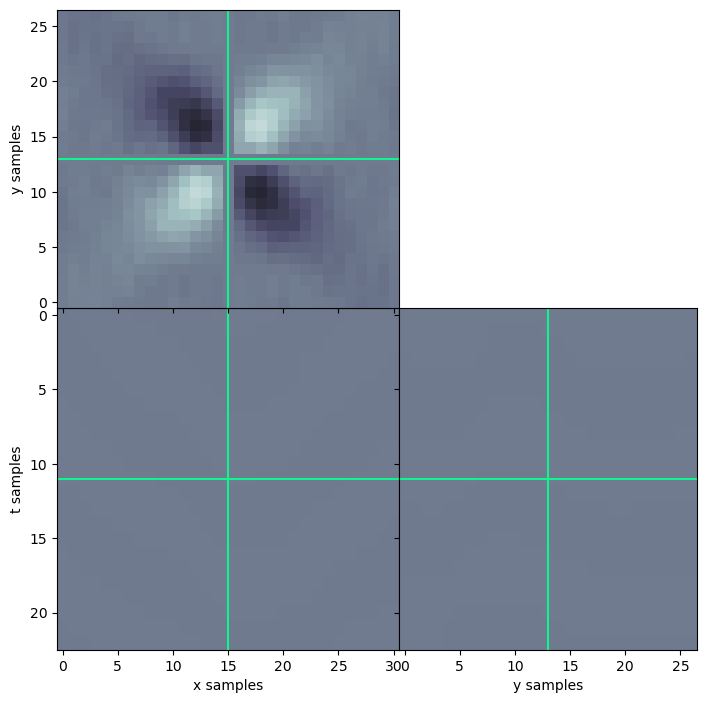

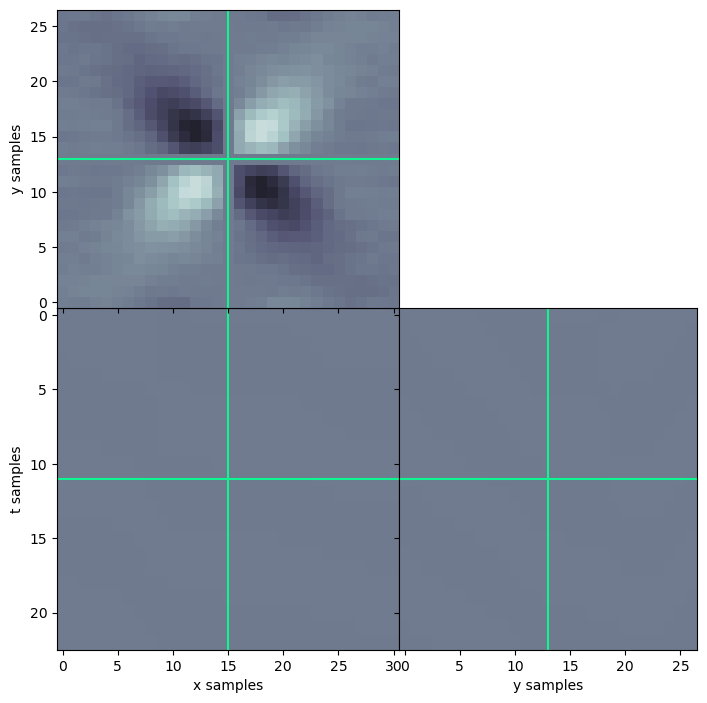

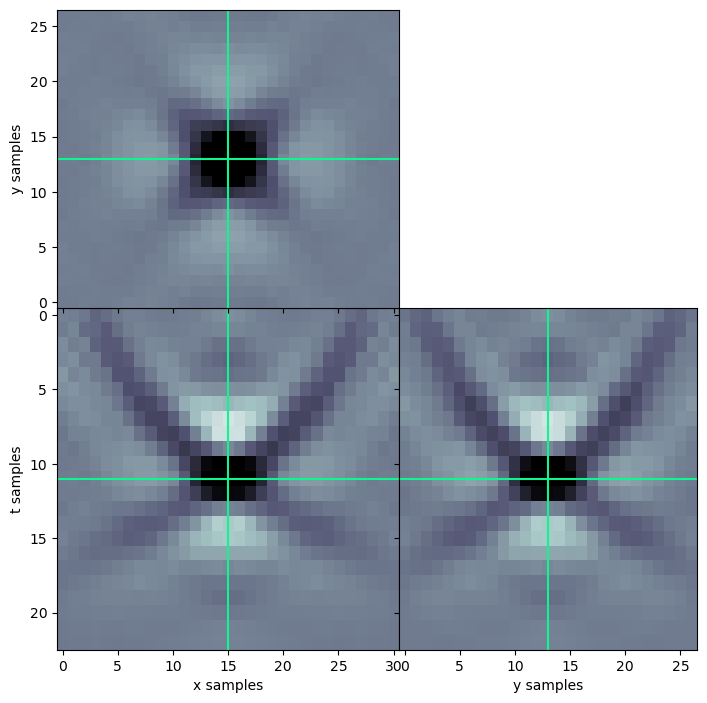

In [104]:
locimage3d(MT_aoi_inv[0], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3])
locimage3d(MT_aoi_inv[1], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3])
locimage3d(MT_aoi_inv[3], sloc_ind[0]-xsi, sloc_ind[1]-ysi, clipval=[-1e-3, 1e-3]);